# Classificação de Grãos de Trigo



## 1. Configuração do ambiente

In [2]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import zipfile


## 2. Aquisição de Dados



In [4]:
col_names = [
    "area",
    "perimeter",
    "compactness",
    "kernel_length",
    "kernel_width",
    "asymmetry_coefficient",
    "groove_length",
    "class"
]

df = pd.read_csv('seeds_dataset.txt', sep=r'\s+', names=col_names)
df.head()

# Definir colunas conforme documentação
col_names = [
    "area","perimeter","compactness","kernel_length","kernel_width",
    "asymmetry_coefficient","groove_length","class"
]

# Carregar DataFrame
df = pd.read_csv('seeds_dataset.txt', sep=r'\s+', names=col_names)
df.head()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry_coefficient,groove_length,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 3. Armazenamento em SQLite


In [5]:
# Conectar ao SQLite e criar tabelas
conn = sqlite3.connect('seeds_data_local.db')
cur = conn.cursor()

cur.executescript("""
CREATE TABLE IF NOT EXISTS raw_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    area REAL, perimeter REAL, compactness REAL,
    kernel_length REAL, kernel_width REAL,
    asymmetry_coefficient REAL, groove_length REAL,
    class INTEGER
);
CREATE TABLE IF NOT EXISTS processed_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    area REAL, perimeter REAL, compactness REAL,
    kernel_length REAL, kernel_width REAL,
    asymmetry_coefficient REAL, groove_length REAL,
    class INTEGER
);
CREATE TABLE IF NOT EXISTS predictions (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    model TEXT, predicted_class INTEGER,
    true_class INTEGER, timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
);
""")

# Inserir dados brutos
df.to_sql('raw_data', conn, if_exists='replace', index=False)
print(f"Registros em raw_data: {pd.read_sql('SELECT COUNT(*) AS cnt FROM raw_data', conn)['cnt'][0]}")

Registros em raw_data: 210


## 4. Pré-processamento e Validação


In [10]:
# Carregar raw_data
raw = pd.read_sql('SELECT * FROM raw_data', conn)

# Validar valores ausentes
assert not raw.isna().any().any(), "Valores ausentes encontrados!"

# Exemplo de formatação: arredondar a 4 casas e validar ranges
raw_fmt = raw.round(4)
assert (raw_fmt['compactness'] >= 0).all(), "Compactness negativo!"

# Escalonamento
scaler = StandardScaler()
X = raw_fmt.drop(columns=['class'])
X_scaled = scaler.fit_transform(X)
processed = pd.DataFrame(X_scaled, columns=X.columns)
processed['class'] = raw_fmt['class']
processed.to_sql('processed_data', conn, if_exists='replace', index=False)
print("Dados processados armazenados em processed_data.")

Dados processados armazenados em processed_data.


## 5. Análise Exploratória


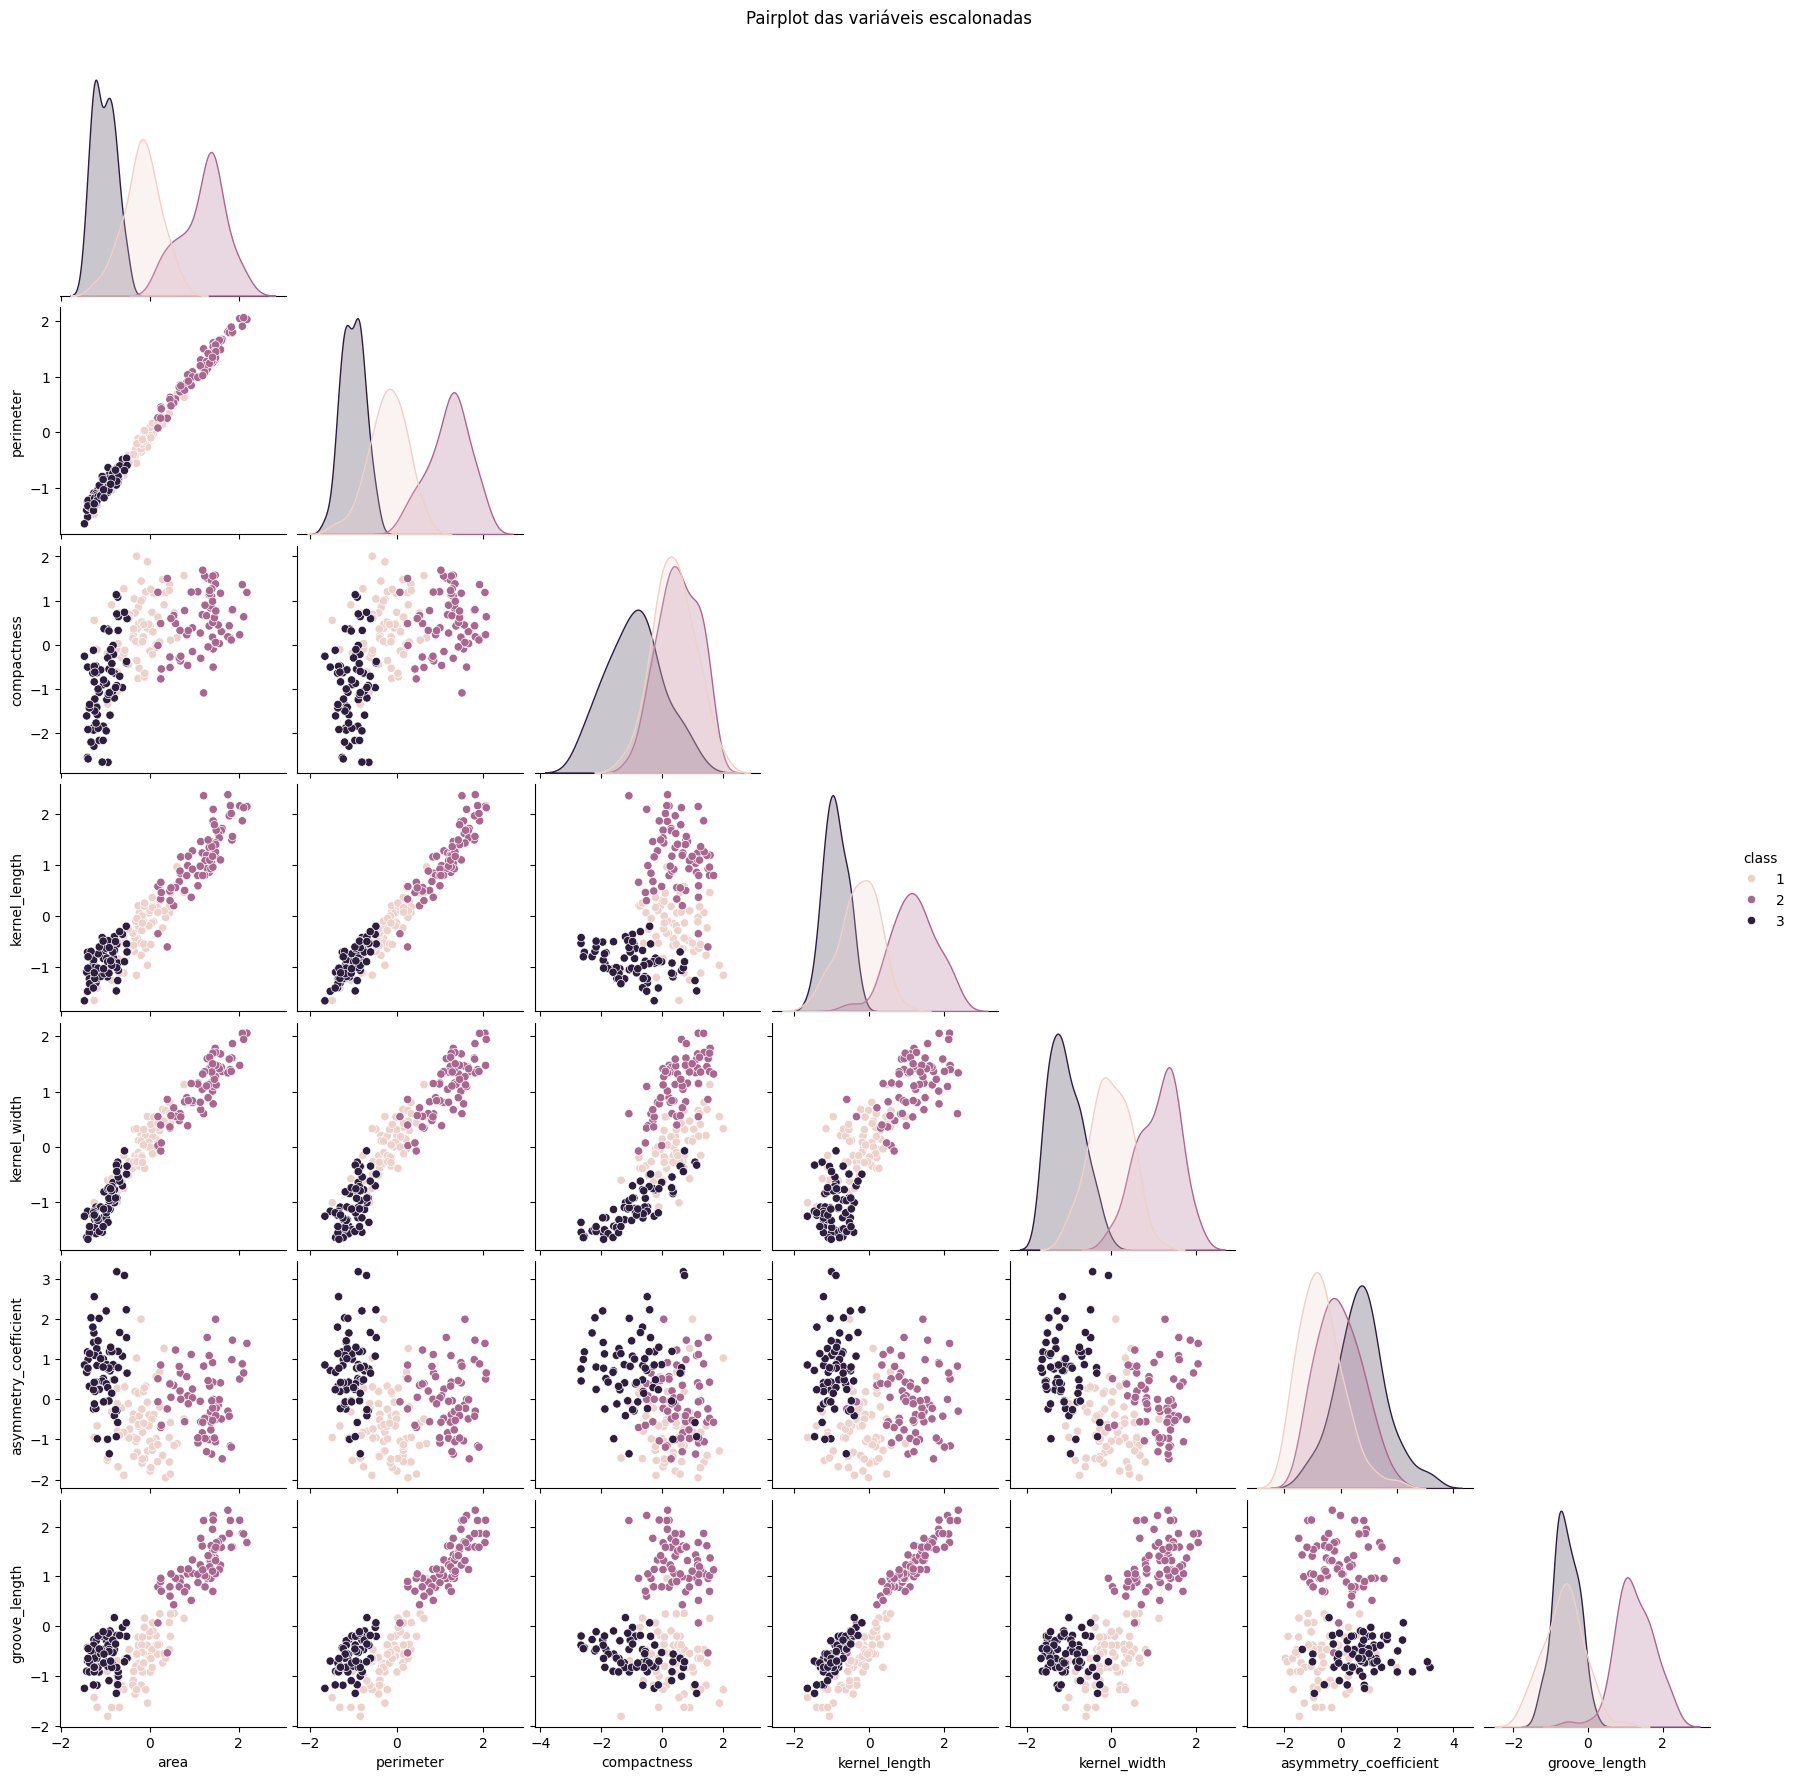

In [7]:
# Pairplot das variáveis escalonadas
sns.pairplot(processed, hue='class', corner=True)
plt.suptitle('Pairplot das variáveis escalonadas', y=1.02)
plt.show()

## 6. Modelagem e Avaliação


In [8]:
# Separar X e y
X = processed.drop(columns='class')
y = processed['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Definir pipelines
pipelines = {
    'knn': Pipeline([('clf', KNeighborsClassifier())]),
    'svm': Pipeline([('clf', SVC())]),
    'rf' : Pipeline([('clf', RandomForestClassifier(random_state=42))])
}

# Treinar e avaliar
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f"--- {name.upper()} ---")
    print(classification_report(y_test, preds, digits=4))

--- KNN ---
              precision    recall  f1-score   support

           1     0.8421    0.7619    0.8000        21
           2     0.9048    0.9048    0.9048        21
           3     0.8696    0.9524    0.9091        21

    accuracy                         0.8730        63
   macro avg     0.8721    0.8730    0.8713        63
weighted avg     0.8721    0.8730    0.8713        63

--- SVM ---
              precision    recall  f1-score   support

           1     0.8421    0.7619    0.8000        21
           2     0.9048    0.9048    0.9048        21
           3     0.8696    0.9524    0.9091        21

    accuracy                         0.8730        63
   macro avg     0.8721    0.8730    0.8713        63
weighted avg     0.8721    0.8730    0.8713        63

--- RF ---
              precision    recall  f1-score   support

           1     0.9444    0.8095    0.8718        21
           2     0.9524    0.9524    0.9524        21
           3     0.8750    1.0000    0.9

## 7. Otimização de Hiperparâmetros


In [9]:
param_grid = {
    'knn': {'clf__n_neighbors': [3,5,7], 'clf__weights': ['uniform','distance']},
    'svm': {'clf__C': [0.1,1,10], 'clf__kernel': ['linear','rbf']},
    'rf' : {'clf__n_estimators': [50,100], 'clf__max_depth': [None,5,10]}
}

best_models = {}
for name, pipe in pipelines.items():
    gs = GridSearchCV(pipe, param_grid[name], cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name.upper()} - Melhores params:", gs.best_params_)

# Avaliação final
for name, model in best_models.items():
    preds = model.predict(X_test)
    print(f"=== {name.upper()} OTIMIZADO ===")
    print(classification_report(y_test, preds, digits=4))

KNN - Melhores params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
SVM - Melhores params: {'clf__C': 10, 'clf__kernel': 'linear'}
RF - Melhores params: {'clf__max_depth': None, 'clf__n_estimators': 50}
=== KNN OTIMIZADO ===
              precision    recall  f1-score   support

           1     0.8421    0.7619    0.8000        21
           2     0.9048    0.9048    0.9048        21
           3     0.8696    0.9524    0.9091        21

    accuracy                         0.8730        63
   macro avg     0.8721    0.8730    0.8713        63
weighted avg     0.8721    0.8730    0.8713        63

=== SVM OTIMIZADO ===
              precision    recall  f1-score   support

           1     0.8095    0.8095    0.8095        21
           2     0.9474    0.8571    0.9000        21
           3     0.8696    0.9524    0.9091        21

    accuracy                         0.8730        63
   macro avg     0.8755    0.8730    0.8729        63
weighted avg     0.8755    0.8730    0.